In [53]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from sklearn import tree
import pydotplus 
from IPython.display import Image

# Preprocessing data - combine data from games.csv and games_details.csv

### join on games.csv and games_details.csv. add the percentage of 2 point shots successfully made, to the games.csv table

In [82]:
details = pd.read_csv('games_details.csv')
# 'FG3_PCT','FG_PCT',
details=details[details.columns.drop(['TEAM_ABBREVIATION','TEAM_CITY','PLAYER_ID','PLAYER_NAME','NICKNAME','START_POSITION','COMMENT','MIN','PLUS_MINUS'])]
data = pd.read_csv('games.csv')
mean_hpts = data['PTS_home'].mean()
# get the null columns and store them in 'a'
null_columns=data.columns[data.isnull().any()]
data[null_columns].isnull().sum()
a = data[data["REB_away"].isnull()][null_columns]
null_columns=data.columns[data.isnull().any()]
data[null_columns].isnull().sum()
a = data[data["REB_away"].isnull()][null_columns]
a = data[data["REB_away"].isnull()]
# drops all rows with any null columns
data = data.dropna(axis=0,how='any')
data['HOME_TEAM_WINS'] = data['HOME_TEAM_WINS'].replace([1], 'HOME WIN')
data['HOME_TEAM_WINS'] = data['HOME_TEAM_WINS'].replace([0], 'HOME LOSS')
details = details.groupby(['GAME_ID','TEAM_ID']).sum()
details['FG_PCT'] = round(details['FGM']/details['FGA'],3)
details['FT_PCT'] = round(details['FTM']/details['FTA'],3)
details['FG3_PCT'] = round(details['FG3M']/details['FG3A'],3)
details=details.assign(FG2M=(details['FGM']-details['FG3M']))
details=details.assign(FG2A=(details['FGA']-details['FG3A']))
details=details.assign(FG2_PCT=(details['FG2M']/details['FG2A']))
details['FG2_PCT'] = round(details['FG2M']/details['FG2A'],3)
details
# 
# data_2018

<ipython-input-82-bf2c13ebf3a9>:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  details = pd.read_csv('games_details.csv')


FGM    FGA  FG_PCT  FG3M  FG3A  FG3_PCT   FTM   FTA  \
GAME_ID  TEAM_ID                                                            
10300001 1610612742  34.0   76.0   0.447   2.0   8.0    0.250  15.0  30.0   
         1610612762  32.0   70.0   0.457   1.0   7.0    0.143  25.0  34.0   
10300002 1610612749  32.0   75.0   0.427   2.0  13.0    0.154  28.0  40.0   
         1610612763  40.0   81.0   0.494   4.0  15.0    0.267  21.0  34.0   
10300003 1610612739  38.0   77.0   0.494   4.0   6.0    0.667  20.0  29.0   
...                   ...    ...     ...   ...   ...      ...   ...   ...   
52000131 1610612763  40.0   90.0   0.444   7.0  22.0    0.318  13.0  24.0   
52000201 1610612754  41.0  100.0   0.410  15.0  41.0    0.366  18.0  21.0   
         1610612764  54.0   93.0   0.581  14.0  28.0    0.500  20.0  26.0   
52000211 1610612744  42.0   94.0   0.447  12.0  34.0    0.353  16.0  20.0   
         1610612763  40.0   98.0   0.408  15.0  35.0    0.429  22.0  26.0   

                     FT_PCT  OREB  ...   REB   AST   STL   BLK    TO    PF  \
GAME_ID  TEAM_ID                   ...                                       
10300001 1610612742   0.500  12.0  ...  38.0  20.0   9.0   4.0  18.0  34.0   
         1610612762   0.735   9.0  ...  41.0  23.0   8.0   4.0  18.0  26.0   
10300002 1610612749   0.700  11.0  ...  43.0  20.0   9.0   4.0  24.0  26.0   
         1610612763   0.618  14.0  ...  48.0  25.0  18.0   7.0  25.0  35.0   
10300003 1610612739   0.690  12.0  ...  52.0  25.0  10.0   7.0  25.0  33.0   
...                     ...   ...  ...   ...   ...   ...   ...   ...   ...   
52000131 1610612763   0.542  11.0  ...  56.0  18.0   4.0  11.0   9.0  19.0   
52000201 1610612754   0.857   9.0  ...  40.0  30.0   9.0   4.0  14.0  19.0   
         1610612764   0.769   7.0  ...  52.0  34.0   7.0   9.0  15.0  20.0   
52000211 1610612744   0.800  11.0  ...  48.0  30.0   7.0   7.0  21.0  23.0   
         1610612763   0.846  16.0  ...  47.0  22.0  14.0   6.0  13.0  23.0   

                       PTS  FG2M  FG2A  FG2_PCT  
GAME_ID  TEAM_ID                                 
10300001 1610612742   85.0  32.0  68.0    0.471  
         1610612762   90.0  31.0  63.0    0.492  
10300002 1610612749   94.0  30.0  62.0    0.484  
         1610612763  105.0  36.0  66.0    0.545  
10300003 1610612739  100.0  34.0  71.0    0.479  
...                    ...   ...   ...      ...  
52000131 1610612763  100.0  33.0  68.0    0.485  
52000201 1610612754  115.0  26.0  59.0    0.441  
         1610612764  142.0  40.0  65.0    0.615  
52000211 1610612744  112.0  30.0  60.0    0.500  
         1610612763  117.0  25.0  63.0    0.397  

[49763 rows x 21 columns]

### use data from the Toronto Raptors 2017 season as a training set, and use it to predict the results of the Toronto Raptors 2018 season (test set)

In [83]:
h=100
data_2018 = data[data['SEASON'] == 2018]#.head(h)
data_2017 = data[data['SEASON'] == 2017]#.head(h)
data_2017=data_2017[data_2017['HOME_TEAM_ID']==1610612761]
data_2018=data_2018[data_2018['HOME_TEAM_ID']==1610612761]
drop_atts = ['GAME_DATE_EST','GAME_STATUS_TEXT','VISITOR_TEAM_ID','SEASON','TEAM_ID_home','TEAM_ID_away']
data_2018=data_2018[data_2018.columns.drop(drop_atts)]
data_2017=data_2017[data_2017.columns.drop(drop_atts)]
data_2017=data_2017.rename(columns={'HOME_TEAM_ID':'TEAM_ID'})
data_2018=data_2018.rename(columns={'HOME_TEAM_ID':'TEAM_ID'})
# details.set_index('GAME_ID').join(data_2017.set_index('GAME_ID'))
# details=details.assign(TEAM=(details['TEAM_ID']*1))
data_17=pd.merge(details, data_2017, on=["GAME_ID","TEAM_ID"])
data_18=pd.merge(details, data_2018, on=["GAME_ID","TEAM_ID"])
# details
# data_2017
# data_17
data_17=data_17[data_17.columns.drop(['TEAM_ID'])]
data_18=data_18[data_18.columns.drop(['TEAM_ID'])]

### Set the X and Y values for the training set. Only keep the 3-point shooting percentage, 2-point shooting percentage, and free-point shooting percentage in the X-table to see which was most important for success.

In [ ]:
# split into X and Y
Y_2017 = data_17['HOME_TEAM_WINS']
# 'FG3_PCT_home','FG3_PCT_away','FG_PCT_home','FG_PCT_away','PTS_home', 'PTS_away','AST_away','AST_home'
drop_cols=['FG_PCT','FG2A','FG2M','PTS','REB_home','AST_home','FG3_PCT_home','FT_PCT_home','FG_PCT_home','PTS_home','GAME_ID','BLK','TO','PF','STL','AST','REB','DREB','OREB','FGM','FGA','FG3M','FG3A','FTM','FTA','HOME_TEAM_WINS','FG3_PCT_away','FG_PCT_away', 'PTS_away','AST_away','FT_PCT_away','REB_away']
X_2017 = data_17[data_17.columns.drop(drop_cols)]
X_2017
# data_2018

### show the resulting decision tree that splits on entropy with max_depth = 2, to find the most important shooting percentage.

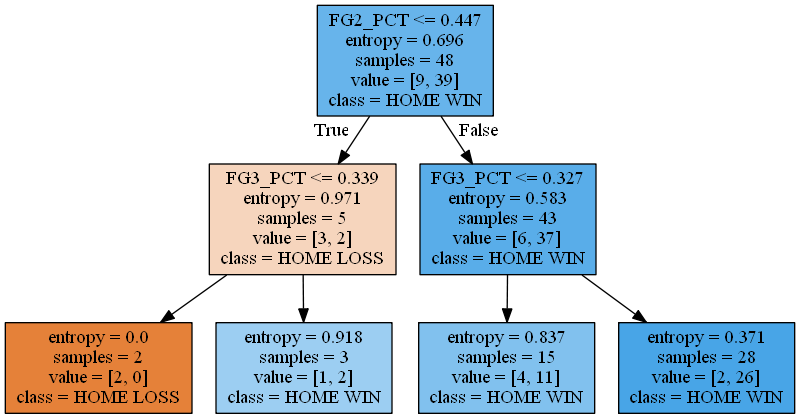

In [92]:
decTree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=2)
decTree = decTree.fit(X_2017,Y_2017)
dot_data = tree.export_graphviz(decTree, feature_names=X_2017.columns, class_names=['HOME LOSS','HOME WIN'], filled=True,
                               out_file=None)

graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())

## Shows that shooting accurately with 2-pointers was the most important for Raptors success, followed by 3-point shooting accuracy.

### Test the data on the 2018 data. Output -> [(number of correct predictions), (number of incorrect predictions)] 

In [94]:
testX = data_18[data_18.columns.drop(drop_cols)]
testY = data_18["HOME_TEAM_WINS"]
predY = decTree.predict(testX)
testset = []
results = [0,0]
for row in testY:
    testset.append(row)
i=0
for row in predY:
    if testset[i] == row:
        results[0] += 1
    else:
        results[1] += 1
results
# testY

[53, 3]

### Data was 95% accurate at predicting 2018 Toronto Raptors results based on shooting percentage statistics in each game.